In [1]:
#Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import twitter
import nltk
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from textblob import TextBlob
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
import pyLDAvis.sklearn
import networkx as nx
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import spacy
import gensim
from sklearn.model_selection import GridSearchCV
from wordcloud import STOPWORDS

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/nguyenngocanh/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/nest.py:1178: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working

/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/nest.py:1179: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working

/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning:

In [2]:
#import twitter key
CONSUMER_KEY = 'IZQ8CyodPG2rNJBLNJbuMWD6y'
CONSUMER_SECRET = 'H8kAZFZ9UlqNOZcMQ4PDvKrg5NIQrTlrK3aU3hWQ3hgT9Obh0C'
OAUTH_TOKEN = '1388067604007370753-R5hHaiG9CW84jpMCTdKeWZwHp9XuUv'
OAUTH_TOKEN_SECRET = 'UvRhAcUt6mWx3W9FxEZ0bahZIhCnTx5HDl3ZTYAfQ1qmS'

#-- login to Twitter with all your authorization details
auth = twitter.oauth.OAuth(OAUTH_TOKEN, OAUTH_TOKEN_SECRET, CONSUMER_KEY, CONSUMER_SECRET)

#-- Create a Twitter 'object' that we will be able to query in your code
twitter_api = twitter.Twitter(auth=auth)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
!pip install -U pip setuptools wheel
!pip install -U spacy
!python -m spacy download en_core_web_sm

## DATA EXPLORATION

Merging - As the collection includes several data batches

In [3]:
#If testing please ignore this cell
#Load the first file
mcu=pd.read_csv('1.csv')
dc=pd.read_csv('DC1.csv')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [4]:
#If testing please ignore this cell
#Merging MCU
for i in range(2,20):
    temp=pd.read_csv(str(i)+'.csv')
    mcu=pd.concat([mcu,temp],axis=0,ignore_index=True)
    
#Merging DC
for i in range(2,16):
    temp=pd.read_csv('DC'+str(i)+'.csv')
    dc=pd.concat([dc,temp],axis=0,ignore_index=True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning:

Columns (6,13,14,18,24,25,37,38) have mixed types.Specify dtype option on import or set low_memory=False.

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning:

Columns (0,2,3,7,9,14,15,18,20,21,22,23,25,26,37,38) have mixed types.Specify dtype option on import or set low_memory=False.



In [ ]:
#If testing run this cell for small batch of data
mcu=pd.read_csv('3.csv')
dc=pd.read_csv('DC3.csv')

Data processing

In [7]:
#Drop duplicated
mcu.drop_duplicates(subset='id',inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [8]:
#Drop duplicated
dc.drop_duplicates(subset='id',inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [9]:
# % of null value
# - It can be seen that most values of geography missing => exlude from analysis
# - Columns that have similar missing values and will be use for analysis includes: 
# created_at, id, text, in_reply, user, lang, extended_tweet, retweeted_status
mcu.isnull().mean()*100

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Unnamed: 0                    0.000000
created_at                    0.000697
id                            0.000697
id_str                        0.000697
text                          0.001394
display_text_range           81.067853
source                        0.002092
truncated                     0.002092
in_reply_to_status_id        85.247650
in_reply_to_status_id_str    85.246953
in_reply_to_user_id          84.874641
in_reply_to_user_id_str      84.874641
in_reply_to_screen_name      84.874641
user                          0.002092
geo                          99.990239
coordinates                  99.990936
place                        99.546114
contributors                 99.999303
is_quote_status               0.001394
extended_tweet               86.156817
quote_count                   0.001394
reply_count                   0.001394
retweet_count                 0.001394
favorite_count                0.001394
entities                      0.001394
favorited                

In [10]:
#clean the data where user is NA
mcu_clean=mcu[mcu.user.isna()==False]
dc_clean=dc[dc.user.isna()==False]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [11]:
#converting time
mcu_clean=mcu_clean.astype({'created_at': 'datetime64'})
dc_clean=dc_clean.astype({'created_at': 'datetime64'})

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [12]:
#checking record time
print(f" MCU Data Available since {mcu_clean.created_at.min()}")
print(f" MCU Data Available upto {mcu_clean.created_at.max()}")
print(f" DC Data Available since {dc_clean.created_at.min()}")
print(f" DC Data Available upto {dc_clean.created_at.max()}")

 MCU Data Available since 2021-05-10 15:54:41
 MCU Data Available upto 2021-05-17 07:19:34
 DC Data Available since 2021-05-10 17:35:41
 DC Data Available upto 2021-05-17 07:14:24


/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [13]:
#as collecting code run in different time - slide data to take same period for MCU and DCEU
mcu_clean=mcu_clean[(mcu_clean.created_at>='2021-05-10 17:35:41') & (mcu_clean.created_at<='2021-05-17 07:14:24')]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [14]:
#reset index
mcu_clean=mcu_clean.reset_index()
dc_clean=dc_clean.reset_index()
mcu_clean.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,index,Unnamed: 0,created_at,id,id_str,text,display_text_range,source,truncated,in_reply_to_status_id,...,timestamp_ms,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status,quoted_status_permalink,possibly_sensitive,extended_entities,hangup,heartbeat_timeout
0,3581,3397,2021-05-10 17:35:45,1391809194395844608.0,1391809194395844608.0,I forgot Benjamin Bratt is in this. Did the MC...,"[0, 59]","<a href=""http://twitter.com/download/iphone"" r...",False,1.391807e+18,...,1.620668e+12,NaN,NaN,NaN,NaN,NaN,False,"{'media': [{'id': 1391809181099909120, 'id_str...",NaN,NaN
1,3582,3398,2021-05-10 17:35:45,1391809197361098752.0,1391809197361098752.0,"Also, I didn't realize Jon Watts would be dire...",NaN,"<a href=""https://mobile.twitter.com"" rel=""nofo...",True,NaN,...,1.620668e+12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3583,3399,2021-05-10 17:35:45,1391809197780656128.0,1391809197780656128.0,RT @infinitystoncs: active payola / promo gc i...,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,...,1.620668e+12,{'created_at': 'Sat May 08 18:54:57 +0000 2021...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3584,3400,2021-05-10 17:35:48,1391809206534168576.0,1391809206534168576.0,RT @SouthpawSwade: Ultron saw Twitter and said...,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,...,1.620668e+12,{'created_at': 'Sun May 09 01:13:27 +0000 2021...,1.390921e+18,1.390921e+18,{'created_at': 'Sat May 08 06:47:35 +0000 2021...,"{'url': 'https://t.co/nuuK6lNesZ', 'expanded':...",NaN,NaN,NaN,NaN
4,3585,3401,2021-05-10 17:35:55,1391809238314405888.0,1391809238314405888.0,RT @naferthekid: no os molaban mas las batalla...,NaN,"<a href=""https://mobile.twitter.com"" rel=""nofo...",False,NaN,...,1.620668e+12,{'created_at': 'Mon May 10 15:11:04 +0000 2021...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
#drop index
mcu_clean.drop(columns=['index','Unnamed: 0'])
dc_clean.drop(columns=['index','Unnamed: 0'])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,created_at,id,id_str,text,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,...,quoted_status_id,quoted_status_id_str,quoted_status,quoted_status_permalink,display_text_range,extended_tweet,possibly_sensitive,extended_entities,hangup,heartbeat_timeout
0,2021-05-10 17:35:41,1.391809e+18,1.391809e+18,RT @LightCastPod: Ray Fisher reminds others th...,"<a href=""http://twitter.com/download/android"" ...",False,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-05-10 17:35:54,1.391809e+18,1.391809e+18,Opa,"<a href=""http://twitter.com/download/android"" ...",False,NaN,NaN,NaN,NaN,...,1.391800e+18,1.391800e+18,{'created_at': 'Mon May 10 16:59:25 +0000 2021...,"{'url': 'https://t.co/qLM7fYQdOU', 'expanded':...",NaN,NaN,NaN,NaN,NaN,NaN
2,2021-05-10 17:36:26,1.391809e+18,1.391809e+18,@drisraelluna Pero con lo fácil q es solo hace...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",True,1.391808e+18,1.391808e+18,1.078164e+18,1.078164e+18,...,NaN,NaN,NaN,NaN,"[14, 140]",{'full_text': '@drisraelluna Pero con lo fácil...,False,NaN,NaN,NaN
3,2021-05-10 17:36:31,1.391809e+18,1.391809e+18,RT @SupesBatsy: Not going to se one WB movie u...,"<a href=""http://twitter.com/download/android"" ...",False,NaN,NaN,NaN,NaN,...,1.391660e+18,1.391660e+18,{'created_at': 'Mon May 10 07:43:58 +0000 2021...,"{'url': 'https://t.co/qgRHX3Rnwa', 'expanded':...",NaN,NaN,NaN,NaN,NaN,NaN
4,2021-05-10 17:36:56,1.391809e+18,1.391809e+18,RT @gamoruh: The women of the DCEU X MCU https...,"<a href=""http://twitter.com/download/android"" ...",False,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,"{'media': [{'id': 1391423363327959049, 'id_str...",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27987,2021-05-17 07:05:50,1.394187e+18,1.394187e+18,@ZanielZ03 WB must pay for destroying DCEU,"<a href=""http://twitter.com/download/iphone"" r...",False,1.394151e+18,1.394151e+18,1.297019e+18,1.297019e+18,...,NaN,NaN,NaN,NaN,"[11, 42]",NaN,NaN,NaN,NaN,NaN
27988,2021-05-17 07:08:09,1.394188e+18,1.394188e+18,RT @TheDCTVSource: Now THIS IS AN EASTER EGG! ...,"<a href=""https://sathwik77.online"" rel=""nofoll...",False,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27989,2021-05-17 07:10:21,1.394189e+18,1.394189e+18,@DCcomicsID DCEU dibeli netflix confirmed???????,"<a href=""http://twitter.com/download/android"" ...",False,1.393841e+18,1.393841e+18,1.127363e+18,1.127363e+18,...,NaN,NaN,NaN,NaN,"[12, 48]",NaN,NaN,NaN,NaN,NaN
27990,2021-05-17 07:13:49,1.394189e+18,1.394189e+18,@UrbanTouchDown @__BobaFett Well yeah but if t...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",True,1.394189e+18,1.394189e+18,1.349035e+18,1.349035e+18,...,NaN,NaN,NaN,NaN,"[28, 140]","{'full_text': ""@UrbanTouchDown @__BobaFett Wel...",NaN,NaN,NaN,NaN


In [18]:
#checking key stats
pd.set_option('display.max_columns',None)
mcu_clean.describe(include='all')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



,index,Unnamed: 0,created_at,id,id_str,text,display_text_range,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,is_quote_status,extended_tweet,quote_count,reply_count,retweet_count,favorite_count,entities,favorited,retweeted,filter_level,lang,timestamp_ms,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status,quoted_status_permalink,possibly_sensitive,extended_entities,hangup,heartbeat_timeout
count,139794.00000,139794.0,139794,139794,1.397940e+05,139794,26349,139794,139794,2.051100e+04,2.051100e+04,2.103700e+04,2.103700e+04,21037,139794,13,13,637,0.0,139794,19334,139794.0,139794.0,139794.0,139794.0,139794,139794,139794,139794,139794,1.397940e+05,76051,3.132600e+04,3.132600e+04,31294,31294,44061,31128,0,0
unique,NaN,55495.0,120631,139794,1.397940e+05,72048,2846,461,2,NaN,1.778300e+04,NaN,NaN,12636,138608,11,11,381,NaN,4,19206,2.0,2.0,2.0,2.0,44579,2,2,1,43,NaN,75856,NaN,NaN,29824,21152,2,7760,0,0
top,NaN,0.0,2021-05-17 01:30:48,1.3941104152615526e+18,1.393908e+18,"RT @FiersaBesari: MCU, Marah-marah Cinematic U...","[0, 140]","<a href=""http://twitter.com/download/iphone"" r...",False,NaN,1.392370e+18,NaN,NaN,MCU,"{'id': 177310510, 'id_str': '177310510', 'name...","{'type': 'Point', 'coordinates': [29.4167, -98...","{'type': 'Point', 'coordinates': [5.7913076, 5...","{'id': '3795cbef20412c50', 'url': 'https://api...",NaN,False,{'full_text': 'TIME TO VOTE! The panel made it...,0.0,0.0,0.0,0.0,"{'hashtags': [], 'urls': [], 'user_mentions': ...",False,False,low,en,NaN,{'created_at': 'Mon May 10 14:49:19 +0000 2021...,NaN,NaN,{'created_at': 'Sat May 15 17:20:35 +0000 2021...,"{'url': 'https://t.co/nuuK6lNesZ', 'expanded':...",False,"{'media': [{'id': 1393933034286551047, 'id_str...",NaN,NaN
freq,NaN,17.0,8,1,1.000000e+00,4530,3681,60143,120460,NaN,1.100000e+02,NaN,NaN,202,15,2,2,37,NaN,94521,8,123411.0,123411.0,123411.0,123411.0,24951,123411,123411,139794,97044,NaN,7,NaN,NaN,16,1099,42264,4530,NaN,NaN
first,NaN,NaN,2021-05-10 17:35:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2021-05-17 07:14:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,75166.54493,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.392299e+18,NaN,7.472021e+17,7.472021e+17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.620933e+12,NaN,1.390051e+18,1.390051e+18,NaN,NaN,NaN,NaN,NaN,NaN
std,43005.99215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.410291e+16,NaN,5.752491e+17,5.752491e+17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.738334e+08,NaN,2.720565e+16,2.720565e+16,NaN,NaN,NaN,NaN,NaN,NaN
min,3581.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.734233e+17,NaN,5.742530e+05,5.742530e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.620668e+12,NaN,1.316942e+09,1.316942e+09,NaN,NaN,NaN,NaN,NaN,NaN
25%,38537.25000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.392223e+18,NaN,1.852140e+09,1.852140e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.620778e+12,NaN,1.391859e+18,1.391859e+18,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
#Taking relevant columns
mcu_short=mcu_clean[['id','created_at','text','in_reply_to_status_id',
                     'in_reply_to_user_id','in_reply_to_screen_name',
                     'user', 'retweeted_status', 'lang', 'extended_tweet']]
dc_short=dc_clean[['id', 'created_at','text','in_reply_to_status_id',
                     'in_reply_to_user_id','in_reply_to_screen_name',
                     'user', 'retweeted_status', 'lang', 'extended_tweet']]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Unpack user column
Taking: user_id, user_name, user_follower, user_following, user_verified, user_status, user_created
Unpack retweet column
Taking: id of original tweet, user id of original tweet

In [41]:
#Convert user column to dictionary
import re
mcu_short['user_dict']=['']*len(mcu_short)
for i in range(len(mcu_short)):
    mcu_short['user_dict'][i]=eval(re.search(r"{.+}", mcu_short['user'][i]).group(0))

dc_short['user_dict']=['']*len(dc_short)
for i in range(len(dc_short)):
    dc_short['user_dict'][i]=eval(re.search(r"{.+}", dc_short['user'][i]).group(0))
    
#Convert retweet column to dictionary
mcu_short['retweet_dict']=['']*len(mcu_short)
for i in range(len(mcu_short)):
    try:
        mcu_short['retweet_dict'][i]=eval(re.search(r"{.+}", mcu_short['retweeted_status'][i]).group(0))
    except TypeError:
        pass
    
dc_short['retweet_dict']=['']*len(dc_short)
for i in range(len(dc_short)):
    try:
        dc_short['retweet_dict'][i]=eval(re.search(r"{.+}", dc_short['retweeted_status'][i]).group(0))
    except TypeError:
        pass
    
#Convert retweet_user column to dictionary
mcu_short['retweet_user_dict']=['']*len(mcu_short)
for i in range(len(mcu_short)):
    try:
        mcu_short['retweet_user_dict'][i]=eval(re.search(r"{.+}", mcu_short['retweeted_status'][i]).group(0))['user']
    except TypeError:
        pass
    
dc_short['retweet_user_dict']=['']*len(dc_short)
for i in range(len(dc_short)):
    try:
        dc_short['retweet_user_dict'][i]=eval(re.search(r"{.+}", dc_short['retweeted_status'][i]).group(0))['user']
    except TypeError:
        pass

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/anaco

In [42]:
#Break down dictionary elements - function
def dict_break(data, dictionary, new_col, old_col, integer):
    if integer=='integer':
        data[new_col]=['']*len(data)
        for i in range(len(data)):
            try:
                data[new_col][i]=int(data[dictionary][i][old_col])
            except TypeError:
                pass
    else:
        data[new_col]=['']*len(data)
        for i in range(len(data)):
            try:
                data[new_col][i]=data[dictionary][i][old_col]
            except TypeError:
                pass

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [43]:
#MCU
#User dictionary
dict_break(mcu_short,'user_dict','user_id','id','integer')
dict_break(mcu_short,'user_dict','user_name','screen_name','string')
dict_break(mcu_short,'user_dict','user_location','location','string')
dict_break(mcu_short,'user_dict','user_created','created_at','string')
dict_break(mcu_short,'user_dict','user_verified','verified','string')
dict_break(mcu_short,'user_dict','user_follower','followers_count','integer')
dict_break(mcu_short,'user_dict','user_following','friends_count','integer')
dict_break(mcu_short,'user_dict','user_like','favourites_count','integer')
dict_break(mcu_short,'user_dict','user_status','statuses_count','integer')
#Retweet dictionary
dict_break(mcu_short,'retweet_dict','in_retweet_to_status_id','id','integer')
#Retweet user dictionary
dict_break(mcu_short,'retweet_user_dict','in_retweet_to_user_id','id','integer')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/anaco

In [44]:
#DC
#User dictionary
dict_break(dc_short,'user_dict','user_id','id','integer')
dict_break(dc_short,'user_dict','user_name','screen_name','string')
dict_break(dc_short,'user_dict','user_location','location','string')
dict_break(dc_short,'user_dict','user_created','created_at','string')
dict_break(dc_short,'user_dict','user_verified','verified','string')
dict_break(dc_short,'user_dict','user_follower','followers_count','integer')
dict_break(dc_short,'user_dict','user_following','friends_count','integer')
dict_break(dc_short,'user_dict','user_like','favourites_count','integer')
dict_break(dc_short,'user_dict','user_status','statuses_count','integer')
#Retweet dictionary
dict_break(dc_short,'retweet_dict','in_retweet_to_status_id','id','integer')
#Retweet user dictionary
dict_break(dc_short,'retweet_user_dict','in_retweet_to_user_id','id','integer')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/anaco

In [45]:
#recheck NA
mcu_short.isnull().mean()*100

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



id                          0.000000
created_at                  0.000000
text                        0.000000
in_reply_to_status_id      85.327696
in_reply_to_user_id        84.951429
in_reply_to_screen_name    84.951429
user                        0.000000
retweeted_status           45.597808
lang                        0.000000
extended_tweet             86.169650
user_dict                   0.000000
retweet_dict                0.000000
retweet_user_dict           0.000000
user_id                     0.000000
user_name                   0.000000
user_location              30.200152
user_created                0.000000
user_verified               0.000000
user_follower               0.000000
user_following              0.000000
user_like                   0.000000
user_status                 0.000000
in_retweet_to_status_id     0.000000
in_retweet_to_user_id       0.000000
dtype: float64

In [46]:
#checking on location again - not standardised => remove
mcu_short.user_location.value_counts()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



she/her                            1653
United States                       800
Los Angeles, CA                     456
Indonesia                           351
he/him                              343
                                   ... 
⠀⠀⠀⠀⠀⠀⠀⠀﹙. . .﹚⠀𝐍𝐄𝐖    𝐎𝐑𝐋𝐄𝐀𝐍𝐒.       1
Aespa and snsd                        1
(𝙨𝙝𝙚/𝙝𝙚𝙧)                             1
liampayne, 1993, reino unido          1
Pop's CHOCK'LIT SHOPPE 🥤              1
Name: user_location, Length: 36207, dtype: int64

In [47]:
mcu_short.drop(columns='user_location')
dc_short.drop(columns='user_location')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,id,created_at,text,in_reply_to_status_id,in_reply_to_user_id,in_reply_to_screen_name,user,retweeted_status,lang,extended_tweet,user_dict,retweet_dict,retweet_user_dict,user_id,user_name,user_created,user_verified,user_follower,user_following,user_like,user_status,in_retweet_to_status_id,in_retweet_to_user_id
0,1.391809e+18,2021-05-10 17:35:41,RT @LightCastPod: Ray Fisher reminds others th...,NaN,NaN,NaN,"{'id': 266222461, 'id_str': '266222461', 'name...",{'created_at': 'Mon May 10 17:19:04 +0000 2021...,en,NaN,"{'id': 266222461, 'id_str': '266222461', 'name...",{'created_at': 'Mon May 10 17:19:04 +0000 2021...,"{'id': 237993698, 'id_str': '237993698', 'name...",266222461,jokerdaddy23,Mon Mar 14 21:53:59 +0000 2011,False,612,943,39282,24883,1391804998653206530,237993698
1,1.391809e+18,2021-05-10 17:35:54,Opa,NaN,NaN,NaN,"{'id': 820371698264473600, 'id_str': '82037169...",NaN,und,NaN,"{'id': 820371698264473600, 'id_str': '82037169...",,,820371698264473600,Sup3erLane,Sat Jan 14 20:47:09 +0000 2017,False,205,503,3490,1386,,
2,1.391809e+18,2021-05-10 17:36:26,@drisraelluna Pero con lo fácil q es solo hace...,1.391808e+18,1.078164e+18,drisraelluna,"{'id': 1223737271146491914, 'id_str': '1223737...",NaN,es,{'full_text': '@drisraelluna Pero con lo fácil...,"{'id': 1223737271146491914, 'id_str': '1223737...",,,1223737271146491914,Elpapudepapus61,Sat Feb 01 22:38:19 +0000 2020,False,283,275,16097,13490,,
3,1.391809e+18,2021-05-10 17:36:31,RT @SupesBatsy: Not going to se one WB movie u...,NaN,NaN,NaN,"{'id': 98207004, 'id_str': '98207004', 'name':...",{'created_at': 'Mon May 10 09:32:22 +0000 2021...,en,NaN,"{'id': 98207004, 'id_str': '98207004', 'name':...",{'created_at': 'Mon May 10 09:32:22 +0000 2021...,"{'id': 586884216, 'id_str': '586884216', 'name...",98207004,cuthroathoughts,Sun Dec 20 21:21:06 +0000 2009,False,535,450,25078,94685,1391687549689769984,586884216
4,1.391809e+18,2021-05-10 17:36:56,RT @gamoruh: The women of the DCEU X MCU https...,NaN,NaN,NaN,"{'id': 1282109673097834498, 'id_str': '1282109...",{'created_at': 'Sun May 09 16:08:02 +0000 2021...,en,NaN,"{'id': 1282109673097834498, 'id_str': '1282109...",{'created_at': 'Sun May 09 16:08:02 +0000 2021...,"{'id': 1281740622156759040, 'id_str': '1281740...",1282109673097834498,LohVic13,Sun Jul 12 00:31:01 +0000 2020,False,1339,5002,91262,60619,1391424734764601356,1281740622156759040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27987,1.394187e+18,2021-05-17 07:05:50,@ZanielZ03 WB must pay for destroying DCEU,1.394151e+18,1.297019e+18,ZanielZ03,"{'id': 1383738780784287747, 'id_str': '1383738...",NaN,en,NaN,"{'id': 1383738780784287747, 'id_str': '1383738...",,,1383738780784287747,NileshK34079397,Sun Apr 18 11:06:59 +0000 2021,False,46,315,1075,964,,
27988,1.394188e+18,2021-05-17 07:08:09,RT @TheDCTVSource: Now THIS IS AN EASTER EGG! ...,NaN,NaN,NaN,"{'id': 1206541010408333313, 'id_str': '1206541...",{'created_at': 'Mon May 17 06:56:57 +0000 2021...,en,NaN,"{'id': 1206541010408333313, 'id_str': '1206541...",{'created_at': 'Mon May 17 06:56:57 +0000 2021...,"{'id': 1282640770273431552, 'id_str': '1282640...",1206541010408333313,RetweetDc,Mon Dec 16 11:47:16 +0000 2019,False,4885,42,74,200144,1394185152566206467,1282640770273431552
27989,1.394189e+18,2021-05-17 07:10:21,@DCcomicsID DCEU dibeli netflix confirmed???????,1.393841e+18,1.127363e+18,DCcomicsID,"{'id': 66116733, 'id_str': '66116733', 'name':...",NaN,da,NaN,"{'id': 66116733, 'id_str': '66116733', 'name':...",,,66116733,JessenReinhart,Sun Aug 16 13:43:50 +0000 2009,False,498,602,555,13267,,
27990,1.394189e+18,2021-05-17 07:13:49,@UrbanTouchDown @__BobaFett Well yeah but if t...,1.394189e+18,1.349035e+18,UrbanTouchDown,"{'id': 1361228566516613121, 'id_str': '1361228...",NaN,en,"{'full_text': ""@UrbanTouchDown @__BobaFett Wel...","{'id': 1361228566516613121, 'id_str': '1361228...",,,1361228566516613121,DaredevilShill,Mon Feb 15 08:19:27 +0000 2021,False,532,1062,70408,2251

Merging truncated tweet with extended tweet

In [48]:
# merging text with full text
#MCU
import re
mcu_short['full_text']=['']*len(mcu_short)
for i in range(len(mcu_short)):
    try: 
        if mcu_short['extended_tweet'][i] is np.nan:
            mcu_short['full_text'][i]=mcu_short['text'][i]
        else:
            mcu_short['full_text'][i]=eval(re.search(r"{.+}", mcu_short['extended_tweet'][i]).group(0))['full_text']
    except TypeError:
        continue

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/anaco

In [49]:
# merging text with full text
#DC
import re
dc_short['full_text']=['']*len(dc_short)
for i in range(len(dc_short)):
    try: 
        if dc_short['extended_tweet'][i] is np.nan:
            dc_short['full_text'][i]=dc_short['text'][i]
        else:
            dc_short['full_text'][i]=eval(re.search(r"{.+}", dc_short['extended_tweet'][i]).group(0))['full_text']
    except TypeError:
        continue

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/anaco

In [50]:
#Saving the data as the cleaning task processing task very expensive
mcu_short.to_csv('mcu_short.csv')
dc_short.to_csv('dc_short.csv')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [51]:
#Reload data
mcu_short=pd.read_csv('mcu_short.csv')
dc_short=pd.read_csv('dc_short.csv')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [52]:
mcu_short.describe(include='all')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,Unnamed: 0,id,created_at,text,in_reply_to_status_id,in_reply_to_user_id,in_reply_to_screen_name,user,retweeted_status,lang,extended_tweet,user_dict,retweet_dict,retweet_user_dict,user_id,user_name,user_location,user_created,user_verified,user_follower,user_following,user_like,user_status,in_retweet_to_status_id,in_retweet_to_user_id,full_text
count,139794.000000,1.397940e+05,139794,139794,2.051100e+04,2.103700e+04,21037,139794,76051,139794,19334,139794,76051,76051,1.397940e+05,139794,97574,139794,139794,1.397940e+05,1.397940e+05,1.397940e+05,1.397940e+05,7.605100e+04,7.605100e+04,139794
unique,NaN,NaN,120631,72048,NaN,NaN,12636,138608,75856,43,19206,138608,75856,42028,NaN,82807,36206,82485,2,NaN,NaN,NaN,NaN,NaN,NaN,71917
top,NaN,NaN,2021-05-17 01:30:48,"RT @FiersaBesari: MCU, Marah-marah Cinematic U...",NaN,NaN,MCU,"{'id': 177310510, 'id_str': '177310510', 'name...",{'created_at': 'Mon May 10 14:49:19 +0000 2021...,en,{'full_text': 'TIME TO VOTE! The panel made it...,"{'id': 177310510, 'id_str': '177310510', 'name...",{'created_at': 'Mon May 10 14:49:19 +0000 2021...,"{'id': 23790138, 'id_str': '23790138', 'name':...",NaN,dispatchdcu,she/her,Mon Feb 26 15:23:47 +0000 2018,False,NaN,NaN,NaN,NaN,NaN,NaN,"RT @FiersaBesari: MCU, Marah-marah Cinematic U..."
freq,NaN,NaN,8,4530,NaN,NaN,202,15,7,97044,8,15,7,188,NaN,194,1653,194,139209,NaN,NaN,NaN,NaN,NaN,NaN,4530
mean,69896.500000,1.392918e+18,NaN,NaN,1.392299e+18,7.472021e+17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.618270e+17,NaN,NaN,NaN,NaN,2.425858e+03,1.002368e+03,4.081060e+04,3.687077e+04,1.391046e+18,7.959866e+17,NaN
std,40355.196103,7.291101e+14,NaN,NaN,1.410291e+16,5.752491e+17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.734121e+17,NaN,NaN,NaN,NaN,6.113258e+04,5.332878e+03,7.739876e+04,8.655198e+04,1.963900e+16,5.611477e+17,NaN
min,0.000000,1.391809e+18,NaN,NaN,1.734233e+17,5.742530e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.183000e+03,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,5.953266e+17,1.321500e+04,NaN
25%,34948.250000,1.392270e+18,NaN,NaN,1.392223e+18,1.852140e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.509844e+09,NaN,NaN,NaN,NaN,1.020000e+02,1.960000e+02,2.945000e+03,2.708000e+03,1.392126e+18,2.257569e+09,NaN
50%,69896.500000,1.392870e+18,NaN,NaN,1.392825e+18,9.867185e+17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.010203e+18,NaN,NaN,NaN,NaN,3.440000e+02,4.710000e+02,1.477000e+04,1.172750e+04,1.392645e+18,1.013777e+18,NaN
75%,104844.750000,1.393562e+18,NaN,NaN,1.393517e+18,1.268254e+18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.274494e+18,NaN,NaN,NaN,NaN,9.600000e+02,1.051000e+03,4.619975e+04,3.669175e+04,1.393342e+18,1.295467e+18,NaN


In [53]:
dc_short.describe(include='all')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,Unnamed: 0,id,created_at,text,in_reply_to_status_id,in_reply_to_user_id,in_reply_to_screen_name,user,retweeted_status,lang,extended_tweet,user_dict,retweet_dict,retweet_user_dict,user_id,user_name,user_location,user_created,user_verified,user_follower,user_following,user_like,user_status,in_retweet_to_status_id,in_retweet_to_user_id,full_text
count,27992.000000,2.799200e+04,27992,27992,2.609000e+03,2.773000e+03,2773,27992,17987,27992,3331,27992,17987,17987,2.799200e+04,27992,17698,27992,27992,2.799200e+04,27992.000000,2.799200e+04,2.799200e+04,1.798700e+04,1.798700e+04,27992
unique,NaN,NaN,25887,11564,NaN,NaN,1625,27719,17945,35,3308,27719,17945,7918,NaN,19319,8526,19296,2,NaN,NaN,NaN,NaN,NaN,NaN,11540
top,NaN,NaN,2021-05-10 22:45:02,RT @DiscussingFilm: Margot Robbie says she has...,NaN,NaN,Itssan17,"{'id': 713836180626939905, 'id_str': '71383618...",{'created_at': 'Sat May 15 17:17:52 +0000 2021...,en,{'full_text': '@att @hbomax @jasonkilar @Warne...,"{'id': 713836180626939905, 'id_str': '71383618...",{'created_at': 'Sat May 15 17:17:52 +0000 2021...,"{'id': 726643143949447168, 'id_str': '72664314...",NaN,RetweetDc,Gotham City,Mon Dec 16 11:47:16 +0000 2019,False,NaN,NaN,NaN,NaN,NaN,NaN,RT @DiscussingFilm: Margot Robbie says she has...
freq,NaN,NaN,6,2139,NaN,NaN,75,5,3,18968,3,5,3,375,NaN,98,284,98,27884,NaN,NaN,NaN,NaN,NaN,NaN,2139
mean,13995.500000,1.392420e+18,NaN,NaN,1.391884e+18,6.865223e+17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.858605e+17,NaN,NaN,NaN,NaN,1.790027e+03,947.296013,5.019209e+04,5.000072e+04,1.391050e+18,6.964945e+17,NaN
std,8080.738704,6.063282e+14,NaN,NaN,2.939338e+16,5.930469e+17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.735422e+17,NaN,NaN,NaN,NaN,4.227963e+04,2317.247821,8.410577e+04,9.320693e+04,1.746563e+16,5.043857e+17,NaN
min,0.000000,1.391809e+18,NaN,NaN,1.718457e+09,6.735730e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.548260e+05,NaN,NaN,NaN,NaN,0.000000e+00,0.000000,0.000000e+00,1.000000e+00,7.958174e+17,7.815620e+05,NaN
25%,6997.750000,1.391966e+18,NaN,NaN,1.392229e+18,1.036462e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.979594e+09,NaN,NaN,NaN,NaN,7.300000e+01,190.000000,4.477750e+03,4.486250e+03,1.391887e+18,2.896295e+09,NaN
50%,13995.500000,1.392156e+18,NaN,NaN,1.392788e+18,9.263847e+17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.931676e+17,NaN,NaN,NaN,NaN,2.520000e+02,445.000000,1.995800e+04,1.713800e+04,1.391940e+18,7.804608e+17,NaN
75%,20993.250000,1.392664e+18,NaN,NaN,1.393372e+18,1.258921e+18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.228305e+18,NaN,NaN,NaN,NaN,7.360000e+02,979.250000,5.955600e+04,5.468925e+04,1.392222e+18,1.110880e+18,NaN


In [54]:
#Create new column 'network' with retweet and reply original user id
#MCU
mcu_short['network']=['']*len(mcu_short)
for i in range(len(mcu_short)):
    if mcu_short['in_reply_to_user_id'].isnull()[i]==True:
        mcu_short['network'][i]=mcu_short['in_retweet_to_user_id'][i]
    else:
        mcu_short['network'][i]=mcu_short['in_reply_to_user_id'][i]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [55]:
#Create new column 'network' with retweet and reply original user id
#DC
dc_short['network']=['']*len(dc_short)
for i in range(len(dc_short)):
    if dc_short['in_reply_to_user_id'].isnull()[i]==True:
        dc_short['network'][i]=dc_short['in_retweet_to_user_id'][i]
    else:
        dc_short['network'][i]=dc_short['in_reply_to_user_id'][i]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [56]:
#Check unique users of 2 fanbase
print(mcu_short.user_id.nunique())
print(dc_short.user_id.nunique())

82501
19296


/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [57]:
#Final columns to be used
mcu_short=mcu_short[['id','created_at',
                     'in_reply_to_status_id','in_reply_to_user_id',
                     'lang','user_id','user_name',
                     'in_retweet_to_status_id','in_retweet_to_user_id',
                     'full_text','network']]
dc_short=dc_short[['id','created_at',
                     'in_reply_to_status_id','in_reply_to_user_id',
                     'lang','user_id','user_name',
                     'in_retweet_to_status_id','in_retweet_to_user_id',
                     'full_text','network']]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



## Key stats

In [58]:
mcu_short.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,id,created_at,in_reply_to_status_id,in_reply_to_user_id,lang,user_id,user_name,in_retweet_to_status_id,in_retweet_to_user_id,full_text,network
0,1.391809e+18,2021-05-10 17:35:45,1.391807e+18,184635363.0,en,184635363,jacktweetslife,NaN,NaN,I forgot Benjamin Bratt is in this. Did the MC...,184635363.0
1,1.391809e+18,2021-05-10 17:35:45,NaN,NaN,en,816047519880744962,Lobby_Loiterer,NaN,NaN,"Also, I didn't realize Jon Watts would be dire...",NaN
2,1.391809e+18,2021-05-10 17:35:45,NaN,NaN,en,1331232086611677184,lokiswifeee,1.391104e+18,1.378465e+18,RT @infinitystoncs: active payola / promo gc i...,1378464616053882880.0
3,1.391809e+18,2021-05-10 17:35:48,NaN,NaN,en,1099361609976348672,tonia__bisong,1.391200e+18,2.379014e+07,RT @SouthpawSwade: Ultron saw Twitter and said...,23790138.0
4,1.391809e+18,2021-05-10 17:35:55,NaN,NaN,es,900754212748963841,Luisa_mart_garr,1.391773e+18,3.820604e+08,RT @naferthekid: no os molaban mas las batalla...,382060393.0


In [65]:
#Tweet per account MCU
len(mcu_short)/mcu_short.user_id.nunique()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



1.6944521884583217

In [66]:
#Tweet per account DC
len(dc_short)/dc_short.user_id.nunique()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



1.4506633499170813

In [101]:
#Dynamic & spread out of tweet

#MCU
print('MCU')
# % of original post - where the tweet is not reply or retweet
print ('orginal:',len(mcu_short[mcu_short.network.isnull()==True])/len(mcu_short))
# % of reply
print ('reply:', len(mcu_short[mcu_short.in_reply_to_user_id.isnull()==False])/len(mcu_short))
# % of retweet
print ('retweet:', len(mcu_short[mcu_short.in_retweet_to_user_id.isnull()==False])/len(mcu_short))

#DC
print('DC')
# % of original post - where the tweet is not reply or retweet
print ('orginal:',len(dc_short[dc_short.network.isnull()==True])/len(dc_short))
# % of reply
print ('reply:', len(dc_short[dc_short.in_reply_to_user_id.isnull()==False])/len(dc_short))
# % of retweet
print ('retweet:', len(dc_short[dc_short.in_retweet_to_user_id.isnull()==False])/len(dc_short))

MCU
orginal: 0.3054923673405153
reply: 0.15048571469447902
retweet: 0.5440219179650057
DC
orginal: 0.2583595312946556
reply: 0.09906401829094028
retweet: 0.6425764504144041


/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [82]:
#most retweet - MCU
print(mcu_short.in_retweet_to_status_id.value_counts().head(1).values)
mcu_clean[mcu_clean.id==mcu_short.in_retweet_to_status_id.value_counts().head(1).index[0]].text.values

[4530]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



array(['MCU, Marah-marah Cinematic Universe https://t.co/xS3P9sce2f'],
      dtype=object)

In [83]:
#most reply - MCU
print(mcu_short.in_reply_to_status_id.value_counts().head(1).values)
mcu_clean[mcu_clean.id==mcu_short.in_reply_to_status_id.value_counts().head(1).index[0]].text.values

[110]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



array(['ciaoo voglio seguire più moots che amano:\nMCU\nthe vampire diaries \njohnny depp \nonce upon a time \ngrey’s anatomy \nf… https://t.co/sWwYRKrWVZ'],
      dtype=object)

In [85]:
#most retweet - DC
print(dc_short.in_retweet_to_status_id.value_counts().head(1).values)
dc_clean[dc_clean.id==dc_short.in_retweet_to_status_id.value_counts().head(1).index[0]].text.values

[2139]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



array(['Margot Robbie says she has asked WB to introduce Poison Ivy in the DCEU — “They must be sick of hearing it.”\n\n“I’m… https://t.co/CKNdUAUdNn'],
      dtype=object)

In [97]:
#most reply - DC
print(dc_short.in_reply_to_status_id.value_counts().head(1).values)
dc_clean[dc_clean.in_reply_to_status_id==dc_short.in_reply_to_status_id.value_counts().head(1).index[0]].head(4)

[63]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,index,Unnamed: 0,created_at,id,id_str,text,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,retweeted_status,is_quote_status,quote_count,reply_count,retweet_count,favorite_count,entities,favorited,retweeted,filter_level,lang,timestamp_ms,quoted_status_id,quoted_status_id_str,quoted_status,quoted_status_permalink,display_text_range,extended_tweet,possibly_sensitive,extended_entities,hangup,heartbeat_timeout
25925,25940,2305,2021-05-15 18:57:01,1.393642e+18,1.393642e+18,@Itssan17 We talking all of DC or just the DCE...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",False,1.393641e+18,1.393641e+18,2.415349e+09,2.415349e+09,Itssan17,"{'id': 2612543917, 'id_str': '2612543917', 'na...",NaN,NaN,NaN,NaN,NaN,False,0.0,0.0,0.0,0.0,"{'hashtags': [], 'urls': [], 'user_mentions': ...",False,False,low,en,1.621105e+12,NaN,NaN,NaN,NaN,"[10, 129]",NaN,NaN,NaN,NaN,NaN
25929,25944,2309,2021-05-15 18:57:54,1.393642e+18,1.393642e+18,@Itssan17 Best DCEU* movie : ZSJL \nWorst DCEU...,"<a href=""http://twitter.com/download/android"" ...",False,1.393641e+18,1.393641e+18,2.415349e+09,2.415349e+09,Itssan17,"{'id': 955508536540360705, 'id_str': '95550853...",NaN,NaN,NaN,NaN,NaN,False,0.0,0.0,0.0,0.0,"{'hashtags': [], 'urls': [], 'user_mentions': ...",False,False,low,en,1.621105e+12,NaN,NaN,NaN,NaN,"[10, 62]",NaN,NaN,NaN,NaN,NaN
25930,25945,2310,2021-05-15 18:57:56,1.393642e+18,1.393642e+18,@Itssan17 Literally I had huge expectations fr...,"<a href=""http://twitter.com/download/android"" ...",True,1.393641e+18,1.393641e+18,2.415349e+09,2.415349e+09,Itssan17,"{'id': 1386364700632391680, 'id_str': '1386364...",NaN,NaN,NaN,NaN,NaN,False,0.0,0.0,0.0,0.0,"{'hashtags': [], 'urls': [{'url': 'https://t.c...",False,False,low,en,1.621105e+12,NaN,NaN,NaN,NaN,"[10, 140]","{'full_text': ""@Itssan17 Literally I had huge ...",NaN,NaN,NaN,NaN
25935,25950,2315,2021-05-15 19:00:34,1.393642e+18,1.393642e+18,@Itssan17 DCEU-only\nBest: Shazam!\nWorst: Jos...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",False,1.393641e+18,1.393641e+18,2.415349e+09,2.415349e+09,Itssan17,"{'id': 1300446277939978240, 'id_str': '1300446...",NaN,NaN,NaN,NaN,NaN,False,0.0,0.0,0.0,0.0,"{'hashtags': [], 'urls': [], 'user_mentions': ...",False,False,low,en,1.621105e+12,NaN,NaN,NaN,NaN,"[10, 103]",NaN,NaN,NaN,NaN,NaN


/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



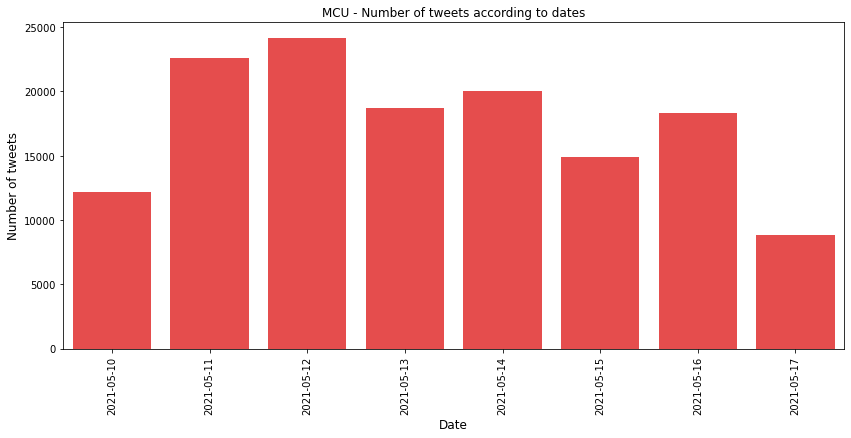

In [176]:
#lets explore created_at column
cnt_srs = mcu_short['created_at'].dt.date.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='red')
plt.xticks(rotation='vertical')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of tweets', fontsize=12)
plt.title("MCU - Number of tweets according to dates")
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



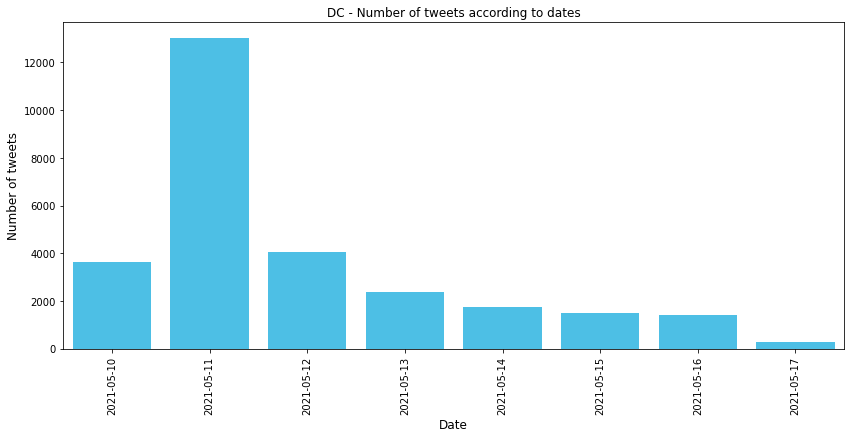

In [61]:
#lets explore created_at column
cnt_srs = dc_short['created_at'].dt.date.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='deepskyblue')
plt.xticks(rotation='vertical')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of tweets', fontsize=12)
plt.title("DC - Number of tweets according to dates")
plt.show()

en     97044
pt     11142
ja      9304
in      6092
es      4643
und     3550
fr      2245
it       837
ro       736
pl       696
ko       631
tr       488
th       484
tl       331
de       284
da       154
ca       119
sl       105
hi       103
ht       102
Name: lang, dtype: int64


/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'MCU - Number of tweets according to language')

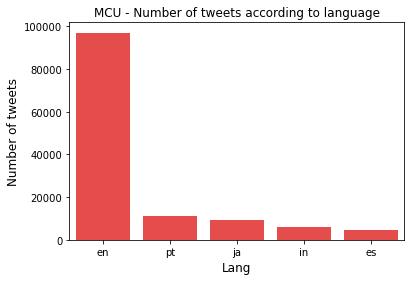

In [184]:
# Language absolute
# MCU
print(mcu_short.lang.value_counts().head(20))
plt.figure(figsize=(6,4))
sns.barplot(mcu_short.lang.value_counts().head(5).index, mcu_short.lang.value_counts().head(5).values, alpha=0.8, color='red')
plt.yticks(np.arange(0, 120000, step=20000))
plt.xlabel('Lang', fontsize=12)
plt.ylabel('Number of tweets', fontsize=12)
plt.title("MCU - Number of tweets according to language")

In [68]:
# Language precentage
# MCU
mcu_short.lang.value_counts()/len(mcu_short)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



en     0.694204
pt     0.079694
ja     0.066562
in     0.043574
es     0.033217
und    0.025392
fr     0.016058
it     0.005987
ro     0.005264
pl     0.004978
ko     0.004513
tr     0.003490
th     0.003462
tl     0.002368
de     0.002031
da     0.001102
ca     0.000851
sl     0.000751
hi     0.000737
ht     0.000730
ar     0.000572
nl     0.000572
et     0.000565
vi     0.000544
cy     0.000508
ru     0.000379
lv     0.000315
is     0.000236
fa     0.000200
eu     0.000179
no     0.000150
lt     0.000122
hu     0.000122
iw     0.000114
sv     0.000100
cs     0.000093
zh     0.000086
fi     0.000079
mr     0.000064
bg     0.000014
ml     0.000007
uk     0.000007
el     0.000007
Name: lang, dtype: float64

en     18968
pt      2083
ko      1788
th      1788
es      1186
und      860
fr       427
ja       191
ht       163
da       122
in        80
ro        69
pl        39
it        31
tr        30
cs        26
et        24
ar        20
tl        20
ca        12
Name: lang, dtype: int64


/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'DC - Number of tweets according to language')

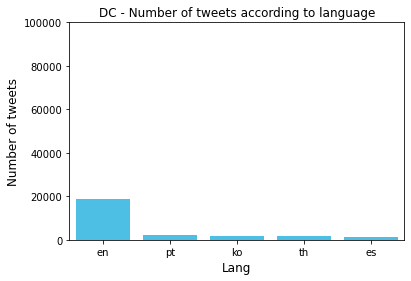

In [182]:
# Language absolute
# DC
print(dc_short.lang.value_counts().head(20))
plt.figure(figsize=(6,4))
sns.barplot(dc_short.lang.value_counts().head(5).index, dc_short.lang.value_counts().head(5).values, alpha=0.8, color='deepskyblue')
plt.yticks(np.arange(0, 120000, step=20000))
plt.xlabel('Lang', fontsize=12)
plt.ylabel('Number of tweets', fontsize=12)
plt.title("DC - Number of tweets according to language")

In [106]:
# Language percentage
# DC
dc_short.lang.value_counts()/len(dc_short)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



en     0.677622
pt     0.074414
ko     0.063875
th     0.063875
es     0.042369
und    0.030723
fr     0.015254
ja     0.006823
ht     0.005823
da     0.004358
in     0.002858
ro     0.002465
pl     0.001393
it     0.001107
tr     0.001072
cs     0.000929
et     0.000857
ar     0.000714
tl     0.000714
ca     0.000429
de     0.000357
ru     0.000357
hu     0.000322
nl     0.000286
sl     0.000179
eu     0.000107
fa     0.000107
lt     0.000107
uk     0.000107
cy     0.000071
fi     0.000071
vi     0.000071
zh     0.000071
sv     0.000071
hi     0.000036
Name: lang, dtype: float64

## Sentiment Analysis 

In [110]:
# Taking English tweet
mcu_en=mcu_short[mcu_short.lang=='en']
dc_en=dc_short[dc_short.lang=='en']

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [112]:
# Sentiment MCU
for index, row in mcu_en['full_text'].iteritems():
    score = SentimentIntensityAnalyzer().polarity_scores(row)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    if neg > pos:
        mcu_en.loc[index, 'sentiment'] = 'negative'
    elif pos > neg:
        mcu_en.loc[index, 'sentiment'] = 'positive'
    else:
        mcu_en.loc[index, 'sentiment'] = 'neutral'
    mcu_en.loc[index, 'neg'] = neg
    mcu_en.loc[index, 'neu'] = neu
    mcu_en.loc[index, 'pos'] = pos
    mcu_en.loc[index, 'compound'] = comp
mcu_en.head(10)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1599: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

,id,created_at,in_reply_to_status_id,in_reply_to_user_id,lang,user_id,user_name,in_retweet_to_status_id,in_retweet_to_user_id,full_text,network,created_at_hour,sentiment,neg,neu,pos,compound
0,1.391809e+18,2021-05-10 17:35:45,1.391807e+18,1.846354e+08,en,184635363,jacktweetslife,NaN,NaN,I forgot Benjamin Bratt is in this. Did the MC...,184635363.0,17,negative,0.147,0.853,0.000,-0.2263
1,1.391809e+18,2021-05-10 17:35:45,NaN,NaN,en,816047519880744962,Lobby_Loiterer,NaN,NaN,"Also, I didn't realize Jon Watts would be dire...",NaN,17,positive,0.000,0.728,0.272,0.8658
2,1.391809e+18,2021-05-10 17:35:45,NaN,NaN,en,1331232086611677184,lokiswifeee,1.391104e+18,1.378465e+18,RT @infinitystoncs: active payola / promo gc i...,1378464616053882880.0,17,positive,0.000,0.706,0.294,0.8092
3,1.391809e+18,2021-05-10 17:35:48,NaN,NaN,en,1099361609976348672,tonia__bisong,1.391200e+18,2.379014e+07,RT @SouthpawSwade: Ultron saw Twitter and said...,23790138.0,17,neutral,0.000,1.000,0.000,0.0000
5,1.391809e+18,2021-05-10 17:35:59,1.391808e+18,1.332121e+06,en,59497005,BrianRCostello,NaN,NaN,@getFANDOM How?! Even if Venom doesn’t become ...,1332121.0,17,neutral,0.000,1.000,0.000,0.0000
6,1.391809e+18,2021-05-10 17:35:59,NaN,NaN,en,2832521293,MykeyMyke88,1.391808e+18,2.553105e+09,RT @ProwlingGambino: Stop arguing about the un...,2553105438.0,17,negative,0.191,0.809,0.000,-0.6369
7,1.391809e+18,2021-05-10 17:36:01,1.391807e+18,1.262184e+18,en,577153263,most_lamentable,NaN,NaN,@notcarseatheadr OMG SAME i loved that red fuc...,1262183885112213504.0,17,negative,0.216,0.585,0.199,-0.0485
8,1.391809e+18,2021-05-10 17:36:02,NaN,NaN,en,70211814,OneChrisEdwards,NaN,NaN,I liked VENOM better than every MCU and DCU mo...,NaN,17,positive,0.000,0.708,0.292,0.8055
9,1.391809e+18,2021-05-10 17:36:02,1.391654e+18,7.480822e+17,en,879634101740896257,thetrueburger17,NaN,NaN,@FrostySnow0__0 I'd say MCU Spider-Man is smar...,748082151258677248.0,17,positive,0.000,0.750,0.250,0.4588
11,1.391809e+18,2021-05-10 17:36:04,NaN,NaN,en,1366156454927990785,scrlettwanda,NaN,NaN,rank my top 6 mcu characters from fav to least...,NaN,17,positive,0.000,0.642,0.358,0.7783


In [113]:
#Sentiment DC
for index, row in dc_en['full_text'].iteritems():
    score = SentimentIntensityAnalyzer().polarity_scores(row)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    if neg > pos:
        dc_en.loc[index, 'sentiment'] = 'negative'
    elif pos > neg:
        dc_en.loc[index, 'sentiment'] = 'positive'
    else:
        dc_en.loc[index, 'sentiment'] = 'neutral'
    dc_en.loc[index, 'neg'] = neg
    dc_en.loc[index, 'neu'] = neu
    dc_en.loc[index, 'pos'] = pos
    dc_en.loc[index, 'compound'] = comp
dc_en.head(10)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1599: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

,id,created_at,in_reply_to_status_id,in_reply_to_user_id,lang,user_id,user_name,in_retweet_to_status_id,in_retweet_to_user_id,full_text,network,created_at_hour,sentiment,neg,neu,pos,compound
0,1.391809e+18,2021-05-10 17:35:41,NaN,NaN,en,266222461,jokerdaddy23,1.391805e+18,2.379937e+08,RT @LightCastPod: Ray Fisher reminds others th...,237993698.0,17,negative,0.130,0.870,0.000,-0.4588
3,1.391809e+18,2021-05-10 17:36:31,NaN,NaN,en,98207004,cuthroathoughts,1.391688e+18,5.868842e+08,RT @SupesBatsy: Not going to se one WB movie u...,586884216.0,17,negative,0.167,0.833,0.000,-0.5574
4,1.391809e+18,2021-05-10 17:36:56,NaN,NaN,en,1282109673097834498,LohVic13,1.391425e+18,1.281741e+18,RT @gamoruh: The women of the DCEU X MCU https...,1281740622156759040.0,17,neutral,0.000,1.000,0.000,0.0000
6,1.391810e+18,2021-05-10 17:37:46,NaN,NaN,en,1142938695915511808,slythbillie,1.391425e+18,1.281741e+18,RT @gamoruh: The women of the DCEU X MCU https...,1281740622156759040.0,17,neutral,0.000,1.000,0.000,0.0000
8,1.391810e+18,2021-05-10 17:40:12,NaN,NaN,en,1175249917108994048,fernandocantu21,NaN,NaN,the DCEU fandom is with you.,NaN,17,neutral,0.000,1.000,0.000,0.0000
10,1.391811e+18,2021-05-10 17:43:23,NaN,NaN,en,4844047200,sergrayson,NaN,NaN,Agshhshss BYEEEE [ CLOSED ],NaN,17,neutral,0.000,1.000,0.000,0.0000
11,1.391811e+18,2021-05-10 17:43:29,NaN,NaN,en,811219351,tntmtheshow,1.378105e+18,7.989623e+17,RT @CB_Legion: This week @MarkReadsComics &amp...,798962331141210112.0,17,neutral,0.000,1.000,0.000,0.0000
12,1.391811e+18,2021-05-10 17:43:52,NaN,NaN,en,931699027330109440,90sman113,1.391805e+18,2.379937e+08,RT @LightCastPod: Ray Fisher reminds others th...,237993698.0,17,negative,0.130,0.870,0.000,-0.4588
15,1.391811e+18,2021-05-10 17:44:22,NaN,NaN,en,997791746477248512,kevish20,NaN,NaN,Could you imagine how many subscribers @hbomax...,NaN,17,negative,0.076,0.924,0.000,-0.4696
16,1.391811e+18,2021-05-10 17:44:34,NaN,NaN,en,4844047200,sergrayson,NaN,NaN,Seb had to bring up DCEU when I’m barely getti...,NaN,17,positive,0.000,0.811,0.189,0.4654


In [114]:
#Count_values for sentiment
def count_values_in_column(data,feature):
    total=data.loc[:,feature].value_counts(dropna=False)
    percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
    return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])


/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [115]:
#MCU sentiment
count_values_in_column(mcu_en,'sentiment')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,Total,Percentage
positive,50914,52.46
neutral,25855,26.64
negative,20275,20.89


In [116]:
#DC sentiment
count_values_in_column(dc_en,'sentiment')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,Total,Percentage
negative,8424,44.41
positive,6959,36.69
neutral,3585,18.90


## Topic modelling 

In [117]:
#clean RT, emoticon,hyperlink
import preprocessor.api as p
from preprocessor.api import clean, set_options
for i in mcu_en.full_text.index:
    mcu_en.full_text[i]=clean(mcu_en.full_text[i])
for i in dc_en.full_text.index:
    dc_en.full_text[i]=clean(dc_en.full_text[i])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3437: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_

In [118]:
#Tokenize function
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
#Lemmatize function
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [120]:
#Clean text - MCU
# Convert to list
mcu_en['clean_text'] = mcu_en.full_text.values.tolist()

# Remove Emails
mcu_en['clean_text'] = [re.sub('\S*@\S*\s?', '', sent) for sent in mcu_en['clean_text']]

# Remove new line characters
mcu_en['clean_text'] = [re.sub('\s+', ' ', sent) for sent in mcu_en['clean_text']]

# Remove distracting single quotes
mcu_en['clean_text'] = [re.sub("\'", "", sent) for sent in mcu_en['clean_text']]

#Tokenize
mcu_en['clean_text'] = list(sent_to_words(mcu_en['clean_text']))

#Lemmarize
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
mcu_en['clean_text'] = lemmatization(mcu_en['clean_text'], allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(mcu_en['clean_text'][:1])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

<>:6: DeprecationWarning:

invalid escape sequence \S

<>:9: DeprecationWarning:

invalid escape sequence \s

<>:6: DeprecationWarning:

invalid escape sequence \S

<>:9: DeprecationWarning:

invalid escape sequence \s

<>:6: DeprecationWarning:

invalid escape sequence \S

<>:9: DeprecationWarning:

invalid escape sequence \s

<ipython-input-120-cb1d3b00eb26>:6: DeprecationWarning:

invalid escape sequence \S

<ipython-input-120-cb1d3b00eb26>:9: DeprecationWarning:

invalid escape sequence \s

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

0    forgot benjamin bratt be do mcu forget too
Name: clean_text, dtype: object


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [121]:
#Clean text - DC
# Convert to list
dc_en['clean_text'] = dc_en.full_text.values.tolist()

# Remove Emails
dc_en['clean_text'] = [re.sub('\S*@\S*\s?', '', sent) for sent in dc_en['clean_text']]

# Remove new line characters
dc_en['clean_text'] = [re.sub('\s+', ' ', sent) for sent in dc_en['clean_text']]

# Remove distracting single quotes
dc_en['clean_text'] = [re.sub("\'", "", sent) for sent in dc_en['clean_text']]

#Tokenize
dc_en['clean_text'] = list(sent_to_words(dc_en['clean_text']))

#Lemmatize
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
dc_en['clean_text'] = lemmatization(dc_en['clean_text'], allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(dc_en['clean_text'][:1])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

<>:6: DeprecationWarning:

invalid escape sequence \S

<>:9: DeprecationWarning:

invalid escape sequence \s

<>:6: DeprecationWarning:

invalid escape sequence \S

<>:9: DeprecationWarning:

invalid escape sequence \s

<>:6: DeprecationWarning:

invalid escape sequence \S

<>:9: DeprecationWarning:

invalid escape sequence \s

<ipython-input-121-96fe3322b8b3>:6: DeprecationWarning:

invalid escape sequence \S

<ipython-input-121-96fe3322b8b3>:9: DeprecationWarning:

invalid escape sequence \s

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

0    ray fisher remind other geoff johns producer c...
Name: clean_text, dtype: object


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [122]:
#use stopword list from wordcloud 
stopwords = list(STOPWORDS)
#append search term in stopwords
stopwords_mcu=stopwords+['mcu']
stopwords_dc=stopwords+['dceu']

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



## Topic modelling

MCU

In [123]:
#Vectorizing
mcu_vectorizer = CountVectorizer(      
                             min_df=5, 
                             max_df=0.8,
                             stop_words=stopwords_mcu, # remove stop words
                             lowercase=True)      

mcu_vectorized = mcu_vectorizer.fit_transform(mcu_en.clean_text)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:391: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.



In [124]:
# GridSearch for LDA
# Define Search Param

search_params = {'n_components': range(5,15)}

# Init the Model
lda = LatentDirichletAllocation(random_state=42)

# Init Grid Search Class
model_mcu = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model_mcu.fit(mcu_vectorized)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



GridSearchCV(estimator=LatentDirichletAllocation(random_state=42),
             param_grid={'n_components': range(5, 15)})

In [125]:
model_mcu.cv_results_

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



{'mean_fit_time': array([107.39784999, 103.68306775,  98.70091443,  95.50417757,
         96.04121251,  94.67728562,  93.09880462,  91.60472422,
         91.33410115,  92.10586576]),
 'std_fit_time': array([1.74879908, 3.13880841, 2.59583142, 0.98511455, 1.32073488,
        1.4951496 , 1.63174115, 0.97946986, 0.99339994, 0.95224034]),
 'mean_score_time': array([2.65917544, 2.52006545, 2.492591  , 2.44533639, 2.49759021,
        2.45098991, 2.35376973, 2.3302249 , 2.32844009, 2.38987222]),
 'std_score_time': array([0.18536906, 0.14338385, 0.13712838, 0.13233832, 0.08759329,
        0.13566058, 0.07839208, 0.14955102, 0.07681484, 0.13298361]),
 'param_n_components': masked_array(data=[5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_components': 5},
  {'n_components': 6},
  {'n_components': 7},
  {'n_components': 8},
  {'n_c

In [106]:
# Store result
component_mcu={}
for i in range(10):
    component_mcu[str(i+5)]= [model_mcu.cv_results_['split0_test_score'][i]]
    component_mcu[str(i+5)].append(model_mcu.cv_results_['split1_test_score'][i])
    component_mcu[str(i+5)].append(model_mcu.cv_results_['split2_test_score'][i])
    component_mcu[str(i+5)].append(model_mcu.cv_results_['split3_test_score'][i])
    component_mcu[str(i+5)].append(model_mcu.cv_results_['split4_test_score'][i])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [107]:
component_mcu=pd.DataFrame(component_mcu)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



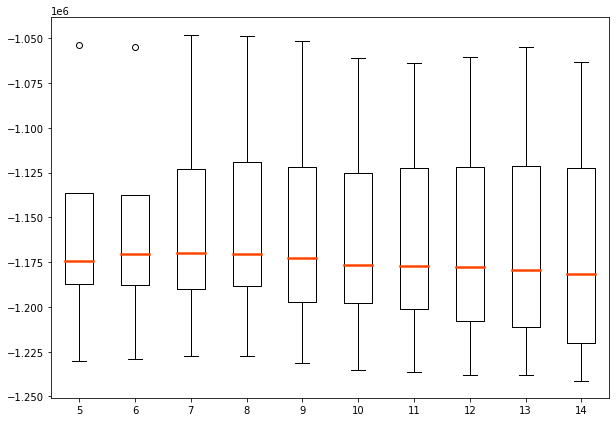

In [113]:
# plot result's distribution
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)
medianprops = dict(linestyle='-', linewidth=2.5, color='orangered')
plt.boxplot(component_mcu, medianprops = medianprops)
ax.set_xticklabels(component_mcu.columns)
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.show()

DCEU

In [128]:
#Vectorizing
dc_vectorizer = CountVectorizer(      
                             min_df=5, 
                             max_df=0.8,
                             stop_words=stopwords_dc, # remove stop words
                             lowercase=True)       

dc_vectorized = dc_vectorizer.fit_transform(dc_en.clean_text)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:391: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.



In [129]:
# GridSearch for LDA
# Define Search Param

search_params = {'n_components': range(5,15)}

# Init the Model
lda = LatentDirichletAllocation(random_state=42)

# Init Grid Search Class
model_dc = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model_dc.fit(dc_vectorized)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



GridSearchCV(estimator=LatentDirichletAllocation(random_state=42),
             param_grid={'n_components': range(5, 15)})

In [130]:
model_dc.cv_results_

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



{'mean_fit_time': array([17.59508414, 16.87363243, 16.36359587, 16.4640223 , 16.23756938,
        16.33037004, 16.22506914, 16.19350104, 15.96041865, 15.92495394]),
 'std_fit_time': array([0.49859693, 0.30521562, 0.48442006, 0.4219556 , 0.34916114,
        0.36877934, 0.36749676, 0.50162749, 0.45142881, 0.39688786]),
 'mean_score_time': array([0.40741463, 0.41038661, 0.39720407, 0.40526762, 0.39728117,
        0.40841947, 0.4109683 , 0.42152171, 0.41807852, 0.41784258]),
 'std_score_time': array([0.02781909, 0.01363007, 0.01522881, 0.03436464, 0.02900222,
        0.02870137, 0.04611916, 0.03273015, 0.042986  , 0.03367626]),
 'param_n_components': masked_array(data=[5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_components': 5},
  {'n_components': 6},
  {'n_components': 7},
  {'n_components': 8},
  {'n_components': 9},
  

In [118]:
#store the result
component_dc={}
for i in range(10):
    component_dc[str(i+5)]= [model_dc.cv_results_['split0_test_score'][i]]
    component_dc[str(i+5)].append(model_dc.cv_results_['split1_test_score'][i])
    component_dc[str(i+5)].append(model_dc.cv_results_['split2_test_score'][i])
    component_dc[str(i+5)].append(model_dc.cv_results_['split3_test_score'][i])
    component_dc[str(i+5)].append(model_dc.cv_results_['split4_test_score'][i])
component_dc=pd.DataFrame(component_dc)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



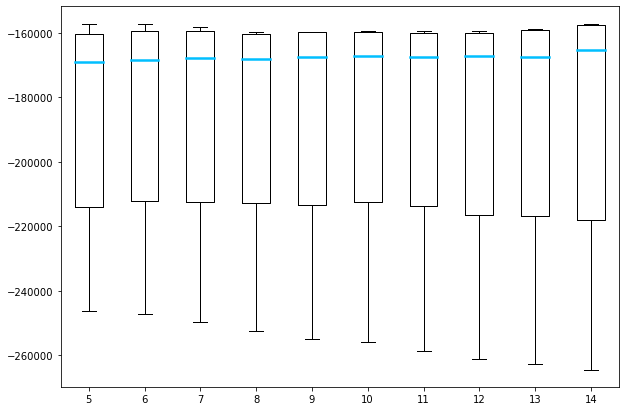

In [120]:
#plot the result
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)
medianprops = dict(linestyle='-', linewidth=2.5, color='deepskyblue')
plt.boxplot(component_dc, medianprops = medianprops)
ax.set_xticklabels(component_dc.columns)
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.show()

Final topic choice

In [132]:
# Display keywork function
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [133]:
# MCU topic with LDA
vectorizer = CountVectorizer(      
                             min_df=5, 
                             max_df=0.8,
                             stop_words=stopwords_mcu,             # remove stop words
                             lowercase=True)  # num chars >       

mcu_vectorized = vectorizer.fit_transform(mcu_en.clean_text)
mcu_feature_names = vectorizer.get_feature_names()
lda_mcu = LatentDirichletAllocation(n_components=8,random_state=42)
lda_mcu.fit(mcu_vectorized)
display_topics(lda_mcu, mcu_feature_names, no_top_words=15)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Topic 0:
make good think character movie well bad hulk villain thing people give suit time really
Topic 1:
man spider movie fan iron character go comic venom now marvel way year work true
Topic 2:
scene good end credit say twitter marvel see tony stan enough ultron hate stark literally
Topic 3:
marvel see know come re watch character love go think show want make disney fan
Topic 4:
movie black marvel widow take superhero hot new find solo female st help win good
Topic 5:
new stan moot look war amp disney star reportedly detail series debut august follow wanda
Topic 6:
poster good movie man steve hard ant reason bring back infinity slap amatw return chris
Topic 7:
movie really black soldier winter panther ragnarok favorite holy trinity thor captain fav film good


In [158]:
# MCU topic with NMF
vectorizer = CountVectorizer(      
                             min_df=5, 
                             max_df=0.8,
                             stop_words=stopwords_mcu,             # remove stop words
                             lowercase=True)  # num chars >       

mcu_vectorized = vectorizer.fit_transform(mcu_en.clean_text)
mcu_feature_names = vectorizer.get_feature_names()
nmf_mcu = NMF(n_components=8,random_state=42)
nmf_mcu.fit(mcu_vectorized)
display_topics(nmf_mcu, mcu_feature_names, no_top_words=15)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:391: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.

/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:315: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).



Topic 0:
poster good movie hard man ant slap amatw look disney favorite run start legit strong
Topic 1:
back steve chris evan infinity bring reason return roger good stone credit war go give
Topic 2:
gt show venom wolverine eddie chad wear spider peter see start comic_strip fight movie even
Topic 3:
movie really soldier winter panther black ragnarok holy trinity fav war favorite star dceu watch
Topic 4:
new marvel stan look moot twitter mutual find tony call even loki hate amp literally
Topic 5:
marvel take black widow superhero hot female solo st movie captain fan disney cast come
Topic 6:
good scene end credit win villain character show make need easily decide minute human race
Topic 7:
man spider iron film see venom say character fan think need ultron time way make


In [135]:
# DC topic with LDA
vectorizer = CountVectorizer(      
                             min_df=5, 
                             max_df=0.8,
                             stop_words=stopwords_dc, # remove stop words
                             lowercase=True)        

dc_vectorized = vectorizer.fit_transform(dc_en.clean_text)
dc_feature_names = vectorizer.get_feature_names()
lda_dc = LatentDirichletAllocation(n_components=6,random_state=42)
lda_dc.fit(dc_vectorized)
display_topics(lda_dc, dc_feature_names, no_top_words=15)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:391: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.



Topic 0:
movie snyder film good fan make love well superman see want give zack know people
Topic 1:
poison ivy margot robbie fight harley see keen character constantly john larson brie oscar boyega
Topic 2:
margot robbie ivy say poison ask hear wb introduce sick time want give really bring
Topic 3:
snyder cut want wb time way gotham continue city play series reveal news siren damn
Topic 4:
amp still batman work come plan literally wb future series queen lord hope ben knight
Topic 5:
movie fav favorite marvel mcu dc show war star set ve tv honestly titan ahead


In [145]:
# MCU topic with NMF
vectorizer = CountVectorizer(      
                             min_df=5, 
                             max_df=0.8,
                             stop_words=stopwords_dc,             # remove stop words
                             lowercase=True)  # num chars >       

dc_vectorized = vectorizer.fit_transform(dc_en.clean_text)
dc_feature_names = vectorizer.get_feature_names()
nmf_dc = NMF(n_components=6,random_state=42)
nmf_dc.fit(dc_vectorized)
display_topics(nmf_dc, dc_feature_names, no_top_words=15)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:391: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.

/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:315: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).



Topic 0:
wb say margot ask introduce hear robbie sick ivy poison time want bring give now
Topic 1:
movie fav favorite mcu war star favourite overall good bad make dc shazam even release
Topic 2:
margot robbie character john fight constantly larson brie oscar boyega thompson isaac tessa want give
Topic 3:
amp snyder batman cut wb make series time zack love film want good knight affleck
Topic 4:
poison ivy margot robbie harley see keen geek den speak fight warner pester bro add
Topic 5:
dc ve marvel show original tv set honestly titan ahead somehow comic_strip good amazing universe


Index of each topic

In [159]:
#MCU - Embded tweet with topic
mcu_topic=nmf_mcu.transform(mcu_vectorized)
mcu_en['topic']=mcu_topic.argmax(axis=1)
mcu_en.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,id,created_at,in_reply_to_status_id,in_reply_to_user_id,lang,user_id,user_name,in_retweet_to_status_id,in_retweet_to_user_id,full_text,network,created_at_hour,sentiment,neg,neu,pos,compound,clean_text,topic
0,1.391809e+18,2021-05-10 17:35:45,1.391807e+18,184635363.0,en,184635363,jacktweetslife,NaN,NaN,I forgot Benjamin Bratt is in this. Did the MC...,184635363.0,17,negative,0.147,0.853,0.000,-0.2263,forgot benjamin bratt be do mcu forget too,3
1,1.391809e+18,2021-05-10 17:35:45,NaN,NaN,en,816047519880744962,Lobby_Loiterer,NaN,NaN,"Also, I didn't realize Jon Watts would be dire...",NaN,17,positive,0.000,0.728,0.272,0.8658,also do realize jon watt be direct fantastic m...,7
2,1.391809e+18,2021-05-10 17:35:45,NaN,NaN,en,1331232086611677184,lokiswifeee,1.391104e+18,1.378465e+18,: active payola / promo gc is recruiting !! - ...,1378464616053882880.0,17,positive,0.000,0.706,0.294,0.8092,active payola promo be recruit be add like mai...,4
3,1.391809e+18,2021-05-10 17:35:48,NaN,NaN,en,1099361609976348672,tonia__bisong,1.391200e+18,2.379014e+07,: Ultron saw Twitter and said “that’s about en...,23790138.0,17,neutral,0.000,1.000,0.000,0.0000,ultron see twitter say enough,4
5,1.391809e+18,2021-05-10 17:35:59,1.391808e+18,1332121.0,en,59497005,BrianRCostello,NaN,NaN,How?! Even if Venom doesn’t become part of the...,1332121.0,17,neutral,0.000,1.000,0.000,0.0000,how even venom doesn become part mcu how do li...,7


In [169]:
#MCU - Volumn, sentiment and verbatim of topic
for i in range(8):
    print ('Topic {} has {} tweets, accounting for {}% of total volume. The positive percentage is {}%, negative is {}% and neutral is {}%'.format (
        i, len(mcu_en[mcu_en.topic==i]), len(mcu_en[mcu_en.topic==i])*100/len(mcu_en), 
        len(mcu_en[(mcu_en.topic==i) & (mcu_en.sentiment=='positive')])*100/len(mcu_en[mcu_en.topic==i]),
        len(mcu_en[(mcu_en.topic==i) & (mcu_en.sentiment=='negative')])*100/len(mcu_en[mcu_en.topic==i]),
        len(mcu_en[(mcu_en.topic==i) & (mcu_en.sentiment=='neutral')])*100/len(mcu_en[mcu_en.topic==i])))
    print (mcu_en[(mcu_en.topic==i)]['full_text'].head(20))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Topic 0 has 4705 tweets, accounting for 4.848316227690532% of total volume. The positive percentage is 72.75239107332625%, negative is 12.603613177470775% and neutral is 14.643995749202976%
49                                         is this mcu???
53                                   not the mcu whatever
174                                           he's a WHAT
683                     : MCU does have some cool posters
733     : Emmy awards campaign poster for The Falcon a...
767                                                  yeah
802     : Emmy awards campaign poster for The Falcon a...
819        New Character posters for .Widow Movie is out.
1005    : Emmy awards campaign poster for The Falcon a...
1097    I don't like any of mcu posters. They never gi...
1138    : Emmy awards campaign poster for The Falcon a...
1166                            Zola back in the mcu when
1199                              MCU only for me please.
1203                         Hey everyone how yall doing

In [148]:
#Negative tweets on Topic 7
for i in mcu_en[(mcu_en.topic==7)&(mcu_en.sentiment=='negative')]['full_text']:
    print(i)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



OMG SAME i loved that red fucker so much and prayed for a sam raimi spider-man with carnage in it. I actually loved the st venom in spite of/because it sucked so hard so I'm hoping this new one has the same campy charm that's missing from every mainline mcu trashheap
Raimi and mcu Jonah both used Simmons. Who’s to say Keaton isn’t playing raimi vulture? Or tasm vulture?
No cap, if MCU is going to bog down Spiderman in Avengers bullshit and make his Character more helpessly alligned with Ultimate Spider-man, then maybe I'm more okay with Sony letting Venom have two movies.
: Taskmaster’s MCU costume reminds me of the costume from his limited series mixed with the classic colors the chara…
this is the second tweet ive seen about this on my tl and i think it's racism :/ :/ the only two brown mcu girls lmao
sony's "spider-man" universe having references to ps4 spider-man, mcu spider-man and raimi spider-man at the same time is the exact kind of mess i was eecting from them
Hell yes. I was 

In [139]:
#DC - Embded tweet with topic
dc_topic=nmf_dc.transform(dc_vectorized)
dc_en['topic']=dc_topic.argmax(axis=1)
dc_en.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,id,created_at,in_reply_to_status_id,in_reply_to_user_id,lang,user_id,user_name,in_retweet_to_status_id,in_retweet_to_user_id,full_text,network,created_at_hour,sentiment,neg,neu,pos,compound,clean_text,topic
0,1.391809e+18,2021-05-10 17:35:41,NaN,NaN,en,266222461,jokerdaddy23,1.391805e+18,2.379937e+08,": Ray Fisher reminds others that Geoff Johns, ...",237993698.0,17,negative,0.130,0.870,0.0,-0.4588,ray fisher remind other geoff johns producer c...,3
3,1.391809e+18,2021-05-10 17:36:31,NaN,NaN,en,98207004,cuthroathoughts,1.391688e+18,5.868842e+08,: Not going to se one WB movie until the curre...,586884216.0,17,negative,0.167,0.833,0.0,-0.5574,go wb movie current head be fire fvck dceu,1
4,1.391809e+18,2021-05-10 17:36:56,NaN,NaN,en,1282109673097834498,LohVic13,1.391425e+18,1.281741e+18,: The women of the DCEU X MCU,1281740622156759040.0,17,neutral,0.000,1.000,0.0,0.0000,woman dceu mcu,1
6,1.391810e+18,2021-05-10 17:37:46,NaN,NaN,en,1142938695915511808,slythbillie,1.391425e+18,1.281741e+18,: The women of the DCEU X MCU,1281740622156759040.0,17,neutral,0.000,1.000,0.0,0.0000,woman dceu mcu,1
8,1.391810e+18,2021-05-10 17:40:12,NaN,NaN,en,1175249917108994048,fernandocantu21,NaN,NaN,the DCEU fandom is with you.,NaN,17,neutral,0.000,1.000,0.0,0.0000,dceu fandom be,3


In [168]:
#DC - Volumn, sentiment and verbatim of topic
for i in range(6):
    print ('Topic {} has {} tweets, accounting for {}% of total volume. The positive percentage is {}%, negative is {}% and neutral is {}%'.format (
        i, len(dc_en[dc_en.topic==i]), len(dc_en[dc_en.topic==i])*100/len(dc_en), 
        len(dc_en[(dc_en.topic==i) & (dc_en.sentiment=='positive')])*100/len(dc_en[dc_en.topic==i]),
        len(dc_en[(dc_en.topic==i) & (dc_en.sentiment=='negative')])*100/len(dc_en[dc_en.topic==i]),
        len(dc_en[(dc_en.topic==i) & (dc_en.sentiment=='neutral')])*100/len(dc_en[dc_en.topic==i])))
    print (dc_en[(dc_en.topic==i)]['full_text'].head(20))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Topic 0 has 3965 tweets, accounting for 20.903627161535216% of total volume. The positive percentage is 12.332912988650694%, negative is 79.11727616645649% and neutral is 8.549810844892813%
19                                                Dial H
206    Nope since WB said we are not continuing the S...
307                                                  : …
337                                            Me to WB:
434                                               DO it!
485                                             Cobardes
534    WB are the dumbest hoes on the planet i swear ...
546                          Why is WB the WOOORRSSSTTT?
570    : Margot Robbie says she asks WB to introduce ...
574    : Margot Robbie says she asks WB to introduce ...
575    : Margot Robbie says she asks WB to introduce ...
576                        : Why is WB the WOOORRSSSTTT?
577    : Margot Robbie says she asks WB to introduce ...
578    : Margot Robbie says she asks WB to introduce ...
579    : Mar

In [150]:
#Negative in topic 0 (mostly retweet article)
for i in dc_en[(dc_en.topic==0)&(dc_en.sentiment=='negative')]['full_text']:
    print(i)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



WB are the dumbest hoes on the planet i swear to god
: Margot Robbie says she asks WB to introduce Poison Ivy into the DCEU “all the time”: “They must be sick of hearing it,…
: Margot Robbie says she asks WB to introduce Poison Ivy into the DCEU “all the time”: “They must be sick of hearing it,…
: Margot Robbie says she asks WB to introduce Poison Ivy into the DCEU “all the time”: “They must be sick of hearing it,…
: Margot Robbie says she asks WB to introduce Poison Ivy into the DCEU “all the time”: “They must be sick of hearing it,…
: Margot Robbie says she asks WB to introduce Poison Ivy into the DCEU “all the time”: “They must be sick of hearing it,…
: Margot Robbie says she asks WB to introduce Poison Ivy into the DCEU “all the time”: “They must be sick of hearing it,…
: Margot Robbie says she asks WB to introduce Poison Ivy into the DCEU “all the time”: “They must be sick of hearing it,…
: Margot Robbie says she asks WB to introduce Poison Ivy into the DCEU “all the time”: “They 

In [152]:
#Negative in topic 4 (mostly reply)
for i in dc_en[(dc_en.topic==4)&(dc_en.sentiment=='negative')]['full_text']:
    print(i)

: margot robbie wants poison ivy to join the dceu, and so do i
Ikr! Our badass femme fatale of the DCEU!
starting up a MCU vs DCEU feud i see
We're desperate to see Poison Ivy appear in the DCEU, so we talked to Margot Robbie, aka Harley Quinn, about the possibility
: We're desperate to see Poison Ivy appear in the DCEU, so we talked to Margot Robbie, aka Harley Quinn, about the possibili…
: We're desperate to see Poison Ivy appear in the DCEU, so we talked to Margot Robbie, aka Harley Quinn, about the possibili…
: We're desperate to see Poison Ivy appear in the DCEU, so we talked to Margot Robbie, aka Harley Quinn, about the possibili…
WB should stop fucking around and introduce poison ivy into the DCEU finally so we can have a movie with harley and ivy
Margot Robbie Wants Poison Ivy to Join Harley Quinn in the DCEU Read more at
: Margot Robbie says she regularly pesters Warner Bros about adding Poison Ivy to the DCEU. "I’m very keen to see a Harley-…
: Margot Robbie says she regularl

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [153]:
#Negative in topic 2
for i in dc_en[(dc_en.topic==2)&(dc_en.sentiment=='negative')]['full_text']:
    print(i)

imagina se ele chama a Jlo pra fazer a Mulher Gato no DCEU. - Don't be fooled by the bat that I fought, I'm still, I'm still the kitty from the block.
i kinda wanna do a “who would you recast these dceu characters as” thread but i’m too lazy
Would be awesome but again Warner Bros are cunts and don’t deserve DC characters.
She fighting the good fight
STOP HATING ON WOMEN AND GIVE MARGOT ROBBIE WHAT SHE WANTS!!
she’s fighting the good fight but at what cost
Margot really fights for the people.
she was fighting for gay rights
Margot Robbie, Brie Larson, Tessa Thompson, Oscar Isaac, and John Boyega constantly fighting for their characters to be in queer relationships is something that could be so personal
that was fighting for gay rights
: Margot Robbie, Brie Larson, Tessa Thompson, Oscar Isaac, and John Boyega constantly fighting for their characters to be in qu…
: Margot Robbie, Brie Larson, Tessa Thompson, Oscar Isaac, and John Boyega constantly fighting for their characters to be in qu

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [167]:
for i in dc_en[dc_en.topic==5]['full_text']:
    print(i)

: People who are blindly hating on Peacemaker don’t realize that this show is probably the gateway to getting some really fa…
: People who are blindly hating on Peacemaker don’t realize that this show is probably the gateway to getting some really fa…
and unfortuantely sir, it looks like that threat has manifested. look at it from WB angle. you arent in the DCEU anymore. somehow, they got away with the threat and actually implemented it.
Venom was bad enough to be in the DCEU. Probably not a bad play by Marvel to keep it at arm's length.
: If I was the president of DC films I would've used The Flash movie to soft reboot the DCEU and erase BvS and Josstice Lea…
can you and Bruce Timm come and save DCEU please? We need someone to helm the studio and bring the DC characters to life, you did it best with the original JLA and JLU, can you do it again for live action please?
I’ve been revisiting older episodes! This one was from our original Ee’ in a November ! Featuring . I’ll be sharing so

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Entity detection

In [ ]:
#MCU
#Function to ngram
from sklearn.feature_extraction.text import CountVectorizer
def get_top_n_gram(corpus,ngram_range,n=None):
    vec = CountVectorizer(ngram_range=ngram_range,stop_words = stopwords_mcu).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
#n2_bigram
n2_bigrams = get_top_n_gram(mcu_en.clean_text,(2,2),20)
n2_bigrams

In [ ]:
#DC
#Function to ngram
from sklearn.feature_extraction.text import CountVectorizer
def get_top_n_gram(corpus,ngram_range,n=None):
    vec = CountVectorizer(ngram_range=ngram_range,stop_words = stopwords_dc).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
#n2_bigram
n2_bigrams = get_top_n_gram(dc_en.clean_text,(2,2),20)
n2_bigrams

In [138]:
#save sentiment processing
mcu_en.to_csv('mcu_sentiment.csv',index=None)
dc_en.to_csv('dc_sentiment.csv',index=None)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



## Network analysis

In [3]:
mcu_sentiment=pd.read_csv('mcu_sentiment.csv')
dc_sentiment=pd.read_csv('dc_sentiment.csv')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



MCU

In [5]:
#sliced the network data
mcu_network=mcu_sentiment[mcu_sentiment.network.isnull()==False][['user_id','network']]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [7]:
#remove self-reply
mcu_network=mcu_network[mcu_network.user_id!=mcu_network.network]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [7]:
#save to csv
mcu_network.to_csv('mcu_network.csv',header=None, index=None)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [8]:
#loading the data
G = nx.read_edgelist("mcu_network.csv", delimiter=',', create_using=nx.DiGraph())

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [9]:
# nodes & edges
print(len(G.nodes))
print(len(G.edges))

57216
64787


/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [10]:
#%density
nx.density(G)*100

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



0.001979066899236582

In [14]:
#store the top list of closeness, betweenness, degree, in-degree
sorted_closeness = sorted(nx.closeness_centrality(G).items(), key=lambda kv: kv[1], reverse=True)
sorted_betweenness = sorted(nx.betweenness_centrality(G).items(), key=lambda kv: kv[1], reverse=True)
sorted_indegree = sorted(dict(G.in_degree()).items(), key=lambda kv: kv[1], reverse=True)
sorted_degree = sorted(dict(G.degree()).items(), key=lambda kv: kv[1], reverse=True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [96]:
#check account profile based on top in-degree
for i in sorted_indegree[:30]:
    try:
        # obtain their twitter user information
        profile = twitter_api.users.lookup(user_id=int(float(i[0])))
        # calculating the sentiment of their retweet (meaning their original post) & replies towards them
        sentiment = mcu_sentiment.loc[mcu_sentiment.network==int(float(i[0])),'sentiment']
        print ('- {} ({} - ID: {}) has {} followers, {} interacts from MCU fanbase and {} interacts from DC fanbase'.format(profile[0]['name'], profile[0]['screen_name'] , profile[0]['id'] , profile[0]['followers_count'], i[1], len(dc_network[dc_network.network==float(i[0])])))
        print(sentiment.value_counts()/(len(sentiment)))
    except:
        # inform of deactivated account
        print ('-', int(float(i[0])), 'Error account - deactivated')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



- thena‏ ‏ً (mymyatwaterIoo - ID: 1128089878330130432) has 3030 followers, 3243 interacts from MCU fanbase and 0 interacts from DC fanbase
positive    1.0
Name: sentiment, dtype: float64
- 1301870386003324928 Error account - deactivated
- MCU - The Direct (MCU_Direct - ID: 846923375209594880) has 688915 followers, 2392 interacts from MCU fanbase and 1 interacts from DC fanbase
neutral     0.456306
positive    0.426590
negative    0.117103
Name: sentiment, dtype: float64
- Phase Zero (PhaseZeroCB - ID: 1331429523041226752) has 7474 followers, 2233 interacts from MCU fanbase and 0 interacts from DC fanbase
positive    0.987589
neutral     0.010195
negative    0.002216
Name: sentiment, dtype: float64
- 1002632180995186816 Error account - deactivated
- lara (buckywlsons - ID: 1295467401044209664) has 1663 followers, 1643 interacts from MCU fanbase and 0 interacts from DC fanbase
neutral     0.990367
positive    0.007827
negative    0.001806
Name: sentiment, dtype: float64
- JITCOIN at 67k 

DCEU

In [86]:
#sliced the network data
#remove self-reply
dc_network=dc_sentiment[dc_sentiment.network.isnull()==False][['user_id','network']]
dc_network=dc_network[dc_network.user_id!=dc_network.network]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [11]:
#save the data
dc_network.to_csv('dc_network.csv',header=None, index=None)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [45]:
#load the data
dc_network=pd.read_csv('dc_network.csv')
dc_network.columns = ['user_id','network']

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [11]:
#load the data
G1 = nx.read_edgelist("dc_network.csv", delimiter=',', create_using=nx.DiGraph())

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [12]:
#edges, nodes
print(len(G1.nodes))
print(len(G1.edges))

11746
13475


/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [13]:
#%density
nx.density(G1)*100

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



0.009767552545627155

In [15]:
#calculate closeness, betweenness, degree
sorted_closeness1 = sorted(nx.closeness_centrality(G1).items(), key=lambda kv: kv[1], reverse=True)
sorted_betweenness1 = sorted(nx.betweenness_centrality(G1).items(), key=lambda kv: kv[1], reverse=True)
sorted_indegree1 = sorted(dict(G1.in_degree()).items(), key=lambda kv: kv[1], reverse=True)
sorted_degree1 = sorted(dict(G1.degree()).items(), key=lambda kv: kv[1], reverse=True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [97]:
#check account profile based on top in-degree
for i in sorted_indegree1[:30]:
    try:
        # obtain their twitter user information
        profile = twitter_api.users.lookup(user_id=int(float(i[0])))
        # calculate sentiment of their retweet & reply
        sentiment = dc_sentiment.loc[dc_sentiment.network==int(float(i[0])),'sentiment']
        print ('- {} ({} - ID: {}) has {} followers, {} interacts from DC fanbase and {} interacts from MCU fanbase'.format(profile[0]['name'], profile[0]['screen_name'] , profile[0]['id'] , profile[0]['followers_count'], i[1], len(mcu_network[mcu_network.network==float(i[0])])))
        print(sentiment.value_counts()/(len(sentiment)))
    except:
        # inform of activated account 
        print ('-', int(float(i[0])), 'Error account - deactivated')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



- DiscussingFilm (DiscussingFilm - ID: 780460754910732288) has 224625 followers, 2151 interacts from DC fanbase and 72 interacts from MCU fanbase
negative    0.991701
positive    0.006916
neutral     0.001383
Name: sentiment, dtype: float64
- Film Updates (TheFilmUpdates - ID: 1339619325578240000) has 66696 followers, 772 interacts from DC fanbase and 4 interacts from MCU fanbase
negative    1.0
Name: sentiment, dtype: float64
- wendy (darthvaI - ID: 1093569487) has 9049 followers, 693 interacts from DC fanbase and 9 interacts from MCU fanbase
negative    1.0
Name: sentiment, dtype: float64
- Harley Quinn Updates (HarleyMovieNews - ID: 770014743029579776) has 22476 followers, 466 interacts from DC fanbase and 2 interacts from MCU fanbase
negative    0.995763
positive    0.004237
Name: sentiment, dtype: float64
- Screen Rant (screenrant - ID: 14892220) has 168468 followers, 448 interacts from DC fanbase and 186 interacts from MCU fanbase
negative    0.988987
positive    0.006608
neutral

In [69]:
#Total interact between two fandom
# mcu user in dc base
mutual_user=0
for i in mcu_sentiment.user_id.unique():
    for j in dc_sentiment.user_id.unique():
        if i == j :
            mutual_user+=1

# mcu user reply/ retweet dc base
mcu_interact_with_dc=0
for i in mcu_network.network.unique():
    for j in dc_sentiment.user_id.unique():
        if i == j:
            mcu_interact_with_dc+=1
            
# dc user reply/ retweet mcu base
dc_interact_with_mcu=0
for i in dc_network.network.unique():
    for j in mcu_sentiment.user_id.unique():
        if i == j:
            dc_interact_with_mcu+=1
        
print(mutual_user)
print(mcu_interact_with_dc)
print(dc_interact_with_mcu)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



3992
1108
761


In [70]:
# % among mcu target node
1108/mcu_network.network.nunique()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



0.09097627062977257

In [ ]:
/mcu_network.network.nunique()

In [164]:
mcu_clean.user[0]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



"{'id': 184635363, 'id_str': '184635363', 'name': 'Jack', 'screen_name': 'jacktweetslife', 'location': 'Ad Astra', 'url': 'https://boxd.it/3hET', 'description': 'Lover of random facts. @GuilfordCollege alum. I share opinions on Sports, Politics & Pop Culture. This account reflects my personal views.', 'translator_type': 'none', 'protected': False, 'verified': False, 'followers_count': 914, 'friends_count': 2993, 'listed_count': 58, 'favourites_count': 51224, 'statuses_count': 52983, 'created_at': 'Mon Aug 30 02:32:50 +0000 2010', 'utc_offset': None, 'time_zone': None, 'geo_enabled': True, 'lang': None, 'contributors_enabled': False, 'is_translator': False, 'profile_background_color': '000000', 'profile_background_image_url': 'http://abs.twimg.com/images/themes/theme1/bg.png', 'profile_background_image_url_https': 'https://abs.twimg.com/images/themes/theme1/bg.png', 'profile_background_tile': False, 'profile_link_color': 'DD2E44', 'profile_sidebar_border_color': 'FFFFFF', 'profile_sideb